In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob         # for reading all calibration images 

# read in the calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# calibrate the camera
objpoints = []  # 3D points in real world
imgpoints = []  # 2D points in image space

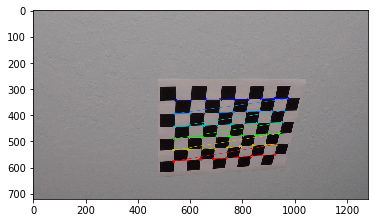

In [8]:
def find_camera_params():
    # since (10,7) image they will have obj points from (0,0,0,) to (9,6,0) 
    # first prepare obj points
    objp = np.zeros((ny*nx,3), np.float32) # Return a new array of given shape and type, filled with zeros
    # Fill the grid with values to (9,6), make a transpose of it and reshape it back to 2 columns, x and y
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for index, fname in enumerate(images):
        # Read in an image
        img = cv2.imread(fname)
        
        # find chessboard corners after converting to greyscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        #if corners found, add to imgpoints and objpoints
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #draw one image with the corners
            if(index==1 ):
                # draw the found corners. img is changed, no return required
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img)
                #plt.show()

find_camera_params()

In [3]:
# Apply color transforms and gradients to the images
def color_and_gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #L-channel
    #s_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255  # return this if you want to check the thresholds
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary[(s_binary == 1) & (sxbinary == 1)] = 1
    #return combined_binary
    #return s_binary
    return combined_binary

In [4]:
# get the perspective transform   
def corners_unwarp(img,src,dst):
    img_size = (img.shape[1], img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    inv_M = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M , inv_M

In [5]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    
    return histogram

In [6]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # plt.imshow(out_img)
    # plt.show()
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) #histogram is a 1D array. This gives the midpoint of that array
    #argmax gives the index of largest value in that axis. 0 is columns, 1 is rows
    leftx_base = np.argmax(histogram[:midpoint])   
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)    # // gives the floor of division
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()   # returns indices of elements non zero with rows equal to size of orig array
    nonzeroy = np.array(nonzero[0])     # cast it to a numpy array. They are both arrays
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    boundaries = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low =  leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # save these boundaries
        boundaries.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        window_rect_left = (win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        window_rect_right = (win_xright_low,win_y_low,win_xright_high,win_y_high)
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]      
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox <= win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix):
            left_mean = np.mean(nonzerox[good_left_inds])
            leftx_current = np.int(left_mean)
        if(len(good_right_inds) > minpix):
            right_mean = np.mean(nonzerox[good_right_inds])
            rightx_current = np.int(right_mean)


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit ,leftx, lefty, rightx, righty,out_img


In [7]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (np.sqrt(np.power(1 + np.square(2 * left_fit[0] * y_eval + left_fit[1]), 3)))/(2 * left_fit[0])	
    right_curverad = (np.sqrt(np.power(1 + np.square(2 * right_fit[0] * y_eval + right_fit[1]), 3)))/(2 * right_fit[0])
    
    return left_curverad, right_curverad

In [34]:
   
def measure_curvature_real(ploty, left_fit, right_fit,leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 3.0/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/550 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
 
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (np.sqrt(np.power(1 + np.square(2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]), 3)))/np.absolute(2 * left_fit_cr[0])    
    right_curverad = (np.sqrt(np.power(1 + np.square(2 * right_fit_cr[0] * y_eval * ym_per_pix+ right_fit_cr[1]), 3)))/np.absolute(2 * right_fit_cr[0])
    
    print("left_fit_cr , right_fit_cr", left_fit_cr, right_fit_cr)
    
    return left_curverad, right_curverad

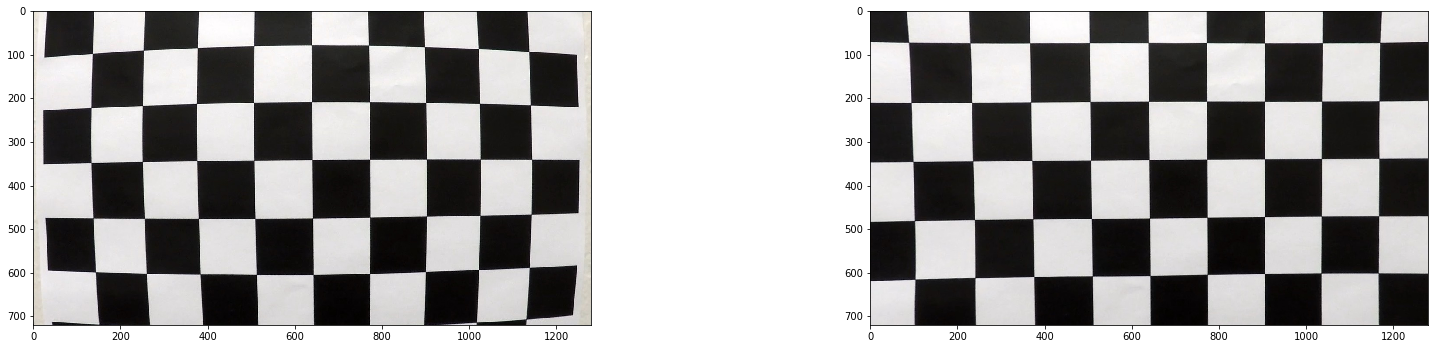

In [9]:
# get the obj and img points
find_camera_params()

# test the calibration and undistortion on an image
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Print distorted and undistorted images
f,(ax1, ax2) = plt.subplots(1,2,figsize=(25,15))
f.subplots_adjust(hspace = 0.2, wspace=0.5)
ax1.imshow(img)
ax2.imshow(undist)

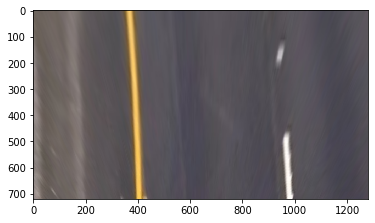

In [35]:
img = mpimg.imread('./test_images/test2.jpg')

src = np.float32([[250,683],[559,472], [724,472], [1042,683]])
dst = np.float32([[350,img.shape[1]], [350,0], [942,0], [942,img.shape[1]]])
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped1,persp_M,persp_inv_M   = corners_unwarp(undist,src,dst)

plt.imshow(warped1)

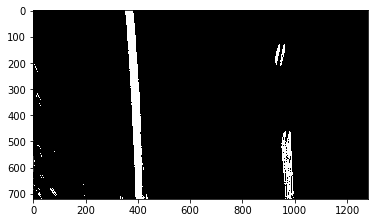

In [36]:
comb_binary = color_and_gradient(warped1)
plt.imshow(comb_binary, cmap='gray')

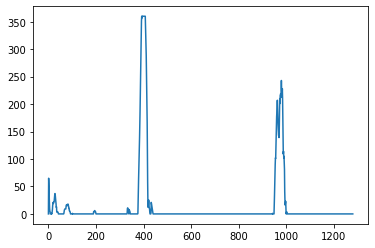

In [37]:
histogram = hist(comb_binary)
plt.plot(histogram)

left_fit_cr , right_fit_cr [-3.57697423e-04  1.91578090e-02  2.47010877e+00] [-1.04016720e-04  1.75545381e-02  6.26094081e+00]


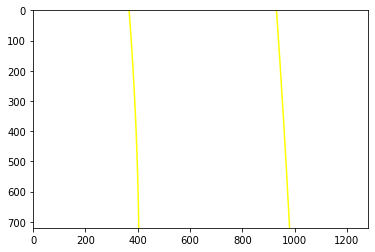

In [38]:
ploty, left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_polynomial(comb_binary)
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit,leftx, lefty, rightx, righty)
#left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)

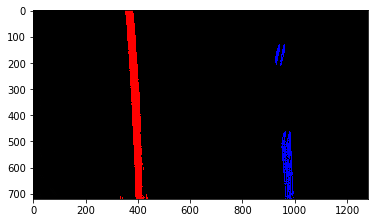

1397.8548633904254 4808.137275880127


In [39]:
result = out_img
# use (arr, cmap='gray') option when you want to show a grey scale image 
#plt.imshow(result, cmap='gray')
plt.imshow(result)
#plt.plot(histogram)
plt.show()
print(left_curverad, right_curverad)